In [1]:
# importing the libraries
# numpy for numerical calculations
# tensor flow for keras model implementation
# matplotlib for plots
# pandas for data processing
# train test split for model sample split
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


# one hot encoder, scaler for data pre processing
# train test split for splitting the data
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Data loading**

In [137]:
# loading all 5 posture data
# supine, prone, side[left, right], straight and unknown

supine = pd.read_csv('supine.csv')
prone = pd.read_csv('prone.csv')
# data_rside = pd.read_csv('right.csv')
# data_lside = pd.read_csv('left.csv')
side = pd.read_csv('side.csv')
sit = pd.read_csv('straight.csv')
unknown = pd.read_csv('unknown.csv')


In [138]:
# combined data of all 5 postures before preprocessing
init_dataset = pd.concat([supine, prone, side, sit, unknown])
init_dataset.reset_index(drop=True, inplace=True)
init_dataset

,ax,ay,az,gx,gy,gz,mx,my,mz,label
0,-0.01,0.00,1.00,1.04,-2.50,0.18,5.11,-49.41,-116.35,supine
1,-0.01,0.00,1.00,1.04,-2.56,0.18,5.16,-49.55,-117.29,supine
2,-0.01,0.00,1.00,0.98,-2.62,0.18,5.19,-49.50,-116.91,supine
3,-0.01,0.00,1.00,1.04,-2.50,0.24,5.24,-49.69,-116.58,supine
4,-0.01,0.00,1.00,0.98,-2.50,0.31,4.69,-49.63,-117.25,supine
...,...,...,...,...,...,...,...,...,...,...
6375,-0.58,0.77,0.27,1.10,-2.56,-0.18,-23.24,-91.93,-61.87,unknown
6376,-0.58,0.77,0.27,2.38,-3.48,-0.49,-23.49,-91.46,-61.88,unknown
6377,-0.57,0.77,0.28,3.30,-6.10,-1.28,-23.46,-90.73,-63.32,unknown
6378,-0.58,0.76,0.27,6.47,-10.25,-13.18,-22.77,-92.05,-62.44,unknown


In [139]:
# to check the GPU availability
# using GPUs as the data model is complex and for parallel computations
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
    print('GPU device not found!!!')
else:
    print('GPU found:', device)


GPU found: /device:GPU:0


**Data preprocessing**

In [140]:
# converting IMU sensor data ax, ay, az, gx, gy, gz, mx, my, mz to x, y, z channels
# data preprocessing
def convert_to_xyz(data):
    x = pd.concat([data['ax'], data['gx'], data['mx']])
    y = pd.concat([data['ay'], data['gy'], data['my']])
    z = pd.concat([data['az'], data['gz'], data['mz']])
    return x, y, z


In [141]:
# preprocessing data for different postures
# creating only 3 channel input using mapping and shuffling
# this utilizes all the 9 features to map to 3 features
def preprocess_posture_data(posture_data, posture_label):
    x, y, z = convert_to_xyz(posture_data)
    posture_df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    posture_df = posture_df.sample(frac=1).reset_index(drop=True)
    posture_df['label'] = posture_label
    return posture_df

In [142]:
# Preprocess data for different postures
formatted_supine = preprocess_posture_data(supine, 'supine')
formatted_prone = preprocess_posture_data(prone, 'prone')
formatted_side = preprocess_posture_data(side, 'side')
formatted_sit = preprocess_posture_data(sit, 'sit')
formatted_unknown = preprocess_posture_data(unknown, 'unknown')

**Data combining**

In [144]:
# combining all the processed 3 channel data - x, y and z
# the final dataset to train the model
final_dataset = pd.concat([formatted_supine, formatted_prone, formatted_side, formatted_sit, formatted_unknown])
final_dataset.reset_index(drop=True, inplace=True)
final_dataset

,x,y,z,label
0,5.38,-49.80,-117.30,supine
1,0.98,-2.32,0.37,supine
2,-0.01,0.00,1.00,supine
3,5.99,-50.87,-117.22,supine
4,6.03,-49.96,-116.80,supine
...,...,...,...,...
19135,-0.54,0.80,0.27,unknown
19136,-0.43,0.87,0.25,unknown
19137,-13.31,3.66,-28.56,unknown
19138,2.38,-6.23,2.69,unknown


**Data splitting**

In [145]:
# data splitting into training, testing, and validation sets
# train:test = 80:20
# test:validate = 50:50
train, test = train_test_split(final_dataset, test_size=0.2)
test, valid = train_test_split(test, test_size=0.5)


In [146]:
# trained features and labels
# validate features and labels
# test features and labels
train_feats = train[['x', 'y', 'z']].values
train_labels = train['label'].values

test_feats = test[['x', 'y', 'z']].values
test_labels = test['label'].values

valid_feats = valid[['x', 'y', 'z']].values
valid_labels = valid['label'].values

In [152]:
# one hot encoder
# to handle multi class classification of postures
# encoder, labels definition
encoder = OneHotEncoder(sparse_output=False)
labels = np.array(['supine', 'prone', 'side', 'sit', 'unknown']).reshape(-1, 1)
encoder.fit(labels)

# defining data encoding
def one_hot_encode(data):
    return encoder.transform(np.array(data).reshape(-1, 1))
# defining data decoding
def decode(encoded_data):
    return encoder.inverse_transform(encoded_data).flatten().tolist()
train_labels
# encoding labels for train, test and validate data
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)
valid_labels = one_hot_encode(valid_labels)


**Model implementation**

In [153]:
# from tensorflow.python.framework import device
device
# tensor flow sequential model with keras API
# normalization added to the model, applying same normalized data during training and inference
# using GPU to execute the tensorflow model
# added complex dense layers for model learning
# output of 5 classes
with tf.device(device):
  normalization_layer = tf.keras.layers.Normalization()
  normalization_layer.adapt(train_feats)
  model = tf.keras.Sequential([
      normalization_layer,
      tf.keras.layers.Dense(6, activation='relu'),
      tf.keras.layers.Dense(12, activation='relu'),
      tf.keras.layers.Dense(24, activation='relu'),
      tf.keras.layers.Dense(24, activation='relu'),
      tf.keras.layers.Dense(48, activation='relu'),
      tf.keras.layers.Dense(24, activation='relu'),
      tf.keras.layers.Dense(12, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])



  # model compilation for training
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



**Model training**

In [154]:
# Model Training with train and validate features, labels
model_history = model.fit(train_feats, train_labels, epochs=80, batch_size=10, validation_data=(valid_feats, valid_labels))

Epoch 1/80
1532/1532 [==============================] - 14s 5ms/step - loss: 1.2153 - accuracy: 0.4383 - val_loss: 1.1562 - val_accuracy: 0.4739
Epoch 2/80
1532/1532 [==============================] - 8s 5ms/step - loss: 1.1668 - accuracy: 0.4661 - val_loss: 1.1567 - val_accuracy: 0.4734
Epoch 3/80
1532/1532 [==============================] - 8s 5ms/step - loss: 0.9832 - accuracy: 0.5822 - val_loss: 0.9111 - val_accuracy: 0.5261
Epoch 4/80
1532/1532 [==============================] - 8s 5ms/step - loss: 0.7784 - accuracy: 0.6781 - val_loss: 0.7277 - val_accuracy: 0.7189
Epoch 5/80
1532/1532 [==============================] - 8s 5ms/step - loss: 0.7395 - accuracy: 0.7042 - val_loss: 0.6811 - val_accuracy: 0.7560
Epoch 6/80
1532/1532 [==============================] - 8s 5ms/step - loss: 0.6918 - accuracy: 0.7412 - val_loss: 0.6394 - val_accuracy: 0.7591
Epoch 7/80
1532/1532 [==============================] - 8s 5ms/step - loss: 0.6843 - accuracy: 0.7270 - val_loss: 0.6296 - val_accuracy

**Model testing**

In [155]:
# test loss and accuracy evaluation
test_loss, test_acc = model.evaluate(test_feats,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

60/60 - 0s - loss: 0.3802 - accuracy: 0.8229 - 154ms/epoch - 3ms/step

Test accuracy: 0.8228840231895447


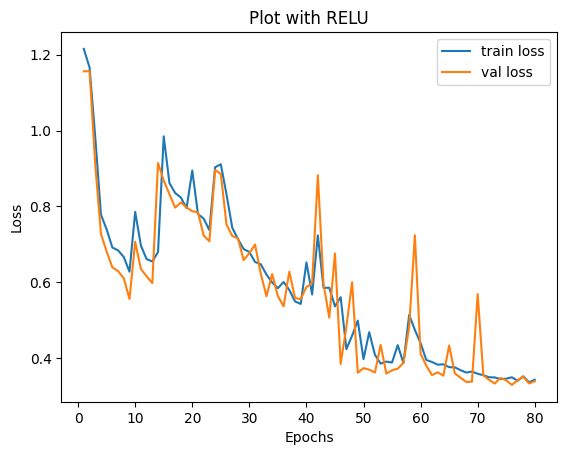

In [156]:
# Plot of training and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot with RELU')
plt.legend()
plt.show()

**Converting TF model to TFLite - TF converter python API**

In [159]:
# converting model to TFLite - without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [160]:
# saving the model
open("tflite_model.tflite", "wb").write(tflite_model)

19968

In [164]:
# installing xxd
!apt-get --qq install xxd

# saving file to .c
!xxd -i tflite_model.tflite > tflite_model.cc
# printing
!cat tflite_model.cc

E: Command line option --qq is not understood in combination with the other options
unsigned char tflite_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0xa0, 0x00, 0x00, 0x00, 0xf8, 0x00, 0x00, 0x00, 0xe0, 0x3d, 0x00, 0x00,
  0xf0, 0x3d, 0x00, 0x00, 0x7c, 0x4d, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x88, 0xff, 0xff, 0xff, 0x1d, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x64, 0x65, 